In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import sys
import re
import glob
import suftware as su
from scipy.stats import norm
from scipy.stats import poisson

e = np.exp(1)
pi = np.pi
def pseudo_log(x,base=e):
    return np.log(x+.5)/np.log(base)

In [2]:
in_dir = '/Users/jkinney/Dropbox/15_mpathic/20_mpathic_redo/20.08.16_mpsa_raw_data'
out_dir = '20.08.16_mpsa_data'

# Get in-file
in_files = glob.glob(f'{in_dir}/results.*.txt')
#in_file = in_files[0]
in_file = f'{in_dir}/results.brca2_9nt_lib1_rep1.txt'

# Determine name of sample
m = re.match(".*/results.(?P<locus>[^_]+)_9nt_(?P<librep>.+).txt",in_file)
locus = m.groupdict()['locus']
librep = m.groupdict()['librep']
name = f'{locus}_{librep}'

# Set parameters
min_ct_per_bc=1
min_num_barcodes=10
num_resamps=100
min_sigma=1E-2 
report_every=10
estimate_mi=True
        
# Create dict to record statistics
stats_dict = {}
        
# Load file
in_df = pd.read_csv(in_file, delimiter='\t', index_col=0)
print(f'Processing {in_file}')

# Remove extraneous columns
del in_df['mis_ct']
del in_df['lib_ct']

# Get total number of barcodes
num_bcs_total = len(in_df)

# Only keep barcodes that have a minimum number of counts in tot_ct samples
ix = (in_df['tot_ct'] >=min_ct_per_bc)
bc_df = in_df[ix]

# Compute the number of splice sites per bc
ss_per_bc = bc_df[['ss','bc']].groupby('ss').count()

# Only keep splice sites that have a minimum number of barcodes
ix = (ss_per_bc['bc'] >= min_num_barcodes)
ss_to_keep = ss_per_bc[ix].index

# Remove barcodes linked to unusued splice sites
ix = bc_df['ss'].isin(ss_to_keep)
bc_df = bc_df[ix]

# Add bc_ct col
bc_df['bc_ct'] = 1

# Marginalize by splice site
ss_df = bc_df.groupby('ss').sum()

# Choose the number of barcodes to be assigned to each splice site during resampling. 
num_ss = len(ss_df)
num_resamps
resamp_bc_cts = np.random.choice(a=ss_df['bc_ct'].values, size=[num_ss, num_resamps], replace=True)
resamp_bc_cols = [f'bc_ct_{x:03d}' for x in range(num_resamps)]
ss_df[resamp_bc_cols] = resamp_bc_cts

# Merge back into bc_df
bc_df_cols = [c for c in bc_df.columns if 'bc_' not in c]
ss_df_cols = [c for c in ss_df.columns if 'bc_' in c]
re_bc_df = pd.merge(left=bc_df[bc_df_cols], right=ss_df[ss_df_cols], left_on='ss', right_index=True)
re_bc_df.reset_index(inplace=True, drop=True)
re_bc_df.head(100)

Processing /Users/jkinney/Dropbox/15_mpathic/20_mpathic_redo/20.08.16_mpsa_raw_data/results.brca2_9nt_lib1_rep1.txt


,tot_ct,ex_ct,ss,bc,bc_ct,bc_ct_000,bc_ct_001,bc_ct_002,bc_ct_003,bc_ct_004,...,bc_ct_090,bc_ct_091,bc_ct_092,bc_ct_093,bc_ct_094,bc_ct_095,bc_ct_096,bc_ct_097,bc_ct_098,bc_ct_099
0,377,27,ACAGCGGGA,TTAGCTATCGGCTGACGTCT,35,11,32,16,19,21,...,18,17,10,26,33,19,32,17,13,15
1,163,0,ACAGCGGGA,ACGCGGAAGATCGTCGGACG,35,11,32,16,19,21,...,18,17,10,26,33,19,32,17,13,15
2,85,2,ACAGCGGGA,GTTACGCGTTCGAATCACGA,35,11,32,16,19,21,...,18,17,10,26,33,19,32,17,13,15
3,79,2,ACAGCGGGA,CAATGCGCCATGATGAGCTC,35,11,32,16,19,21,...,18,17,10,26,33,19,32,17,13,15
4,59,0,ACAGCGGGA,TGACTTGGTAACACTGCAGT,35,11,32,16,19,21,...,18,17,10,26,33,19,32,17,13,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,30,232,CAGGTTAGA,CATTACGACGCACTCCTGTA,14,12,16,20,22,17,...,15,16,20,21,10,13,23,13,24,15
96,28,296,CAGGTTAGA,CGTTTAATCCGGATGCTTTG,14,12,16,20,22,17,...,15,16,20,21,10,13,23,13,24,15
97,26,172,CAGGTTAGA,CGCCAATAAGATTAGGATAC,14,12,16,20,22,17,...,15,16,20,21,10,13,23,13,24,15
98,22,176,CAGGTTAGA,TTCCTTGCCTTAACTGCCGA,14,12,16,20,22,17,...,15,16,20,21,10,13,23,13,24,15


In [3]:
# Create dataframe for recording weights
w_df = re_bc_df.iloc[:,:4].copy()
cols = [c for c in ss_df.columns if 'bc_ct_' in c]
w_df['bc_ct']=1

# Compute poisson mus
wcols = ['w_'+c[-3:] for c in cols]
mus = re_bc_df[cols].values/re_bc_df['bc_ct'].values[:,np.newaxis]
w_df[wcols] = np.random.poisson(lam=mus)

# Compute resampled ex_ct
ex_ct_cols = ['ex_ct_'+c[-3:] for c in wcols]
w_df[ex_ct_cols] = w_df['ex_ct'].values[:,np.newaxis] * w_df[wcols]

# Compute resampled tot_ct
tot_ct_cols = ['tot_ct_'+c[-3:] for c in wcols]
w_df[tot_ct_cols] = w_df['tot_ct'].values[:,np.newaxis] * w_df[wcols]

# Sum by splice site
w_ss_df = w_df.groupby('ss').sum()

# Compute log psi values
lp_values = pseudo_log(w_ss_df[ex_ct_cols].values) - pseudo_log(w_ss_df[tot_ct_cols].values)

# Mask values that have w_xxx < min_num_barcodes
mask = (w_ss_df[wcols].values >= min_num_barcodes)

# Record in w_ss_df
lp_cols = ['lp_'+c[-3:] for c in wcols]
w_ss_df[lp_cols] = np.where(mask, lp_values, np.nan)

# Compute mean and std for lps
w_ss_df['lp'] = pseudo_log(w_ss_df['ex_ct'].values) - pseudo_log(w_ss_df['tot_ct'].values)
w_ss_df['lp_mean'] = w_ss_df[lp_cols].mean(skipna=True, axis=1)
w_ss_df['lp_std'] = w_ss_df[lp_cols].std(skipna=True, axis=1)
w_ss_df['lp_terms'] = mask.sum(axis=1)
w_ss_df.head()

,tot_ct,ex_ct,bc_ct,w_000,w_001,w_002,w_003,w_004,w_005,w_006,...,lp_094,lp_095,lp_096,lp_097,lp_098,lp_099,lp,lp_mean,lp_std,lp_terms
ss,,,,,,,,,,,,,,,,,,,,,
AAAGCAAAA,106,2,15,26,20,20,14,5,24,13,...,-3.845408,NaN,-4.143135,-4.360973,-4.048051,-3.683094,-3.751854,-3.972169,0.534065,89
AAAGCAAAC,96,6,14,10,17,12,13,21,14,15,...,-2.728051,-2.579495,-2.666159,-3.063391,-2.497979,-2.998669,-2.697741,-2.789193,0.308265,94
AAAGCAAAG,89,6,18,19,8,25,17,5,25,19,...,-3.394508,NaN,-2.112964,-2.355032,NaN,-2.228477,-2.622436,-2.842751,0.568762,86
AAAGCAAAT,311,14,27,25,25,31,23,19,32,25,...,NaN,-3.117950,-3.262361,-3.190234,-2.871680,-3.268531,-3.067251,-3.157403,0.447060,93
AAAGCAACA,287,14,35,34,21,20,25,30,23,24,...,-2.708050,-2.676798,-2.451527,NaN,-3.039977,-2.066426,-2.987074,-3.138753,0.780977,88


In [4]:
# Import npeet package
# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)
from mavenn.src.entropy import entropy_continuous

# Estimate H[y|x] for each sequence
w_ss_df['H'] = 0
for i, (ss, row) in enumerate(w_ss_df.iterrows()):
    if i%100==0:
        print('.', end='')
    x = row[lp_cols].dropna().values
    x += .01*np.std(x)*np.random.randn(len(x))  # Add noise to regularize entropy calculation
    x = x.reshape([-1,1])
    H = entropy_continuous(x, knn=5, uncertainty=False)
    w_ss_df.loc[ss, 'H'] = H
    
w_ss_df.head()

['/Users/jkinney/github/mavenn/mavenn']
...........................................................................................................................................................................................................................

,tot_ct,ex_ct,bc_ct,w_000,w_001,w_002,w_003,w_004,w_005,w_006,...,lp_095,lp_096,lp_097,lp_098,lp_099,lp,lp_mean,lp_std,lp_terms,H
ss,,,,,,,,,,,,,,,,,,,,,
AAAGCAAAA,106,2,15,26,20,20,14,5,24,13,...,NaN,-4.143135,-4.360973,-4.048051,-3.683094,-3.751854,-3.972169,0.534065,89,0.931163
AAAGCAAAC,96,6,14,10,17,12,13,21,14,15,...,-2.579495,-2.666159,-3.063391,-2.497979,-2.998669,-2.697741,-2.789193,0.308265,94,0.263143
AAAGCAAAG,89,6,18,19,8,25,17,5,25,19,...,NaN,-2.112964,-2.355032,NaN,-2.228477,-2.622436,-2.842751,0.568762,86,1.027740
AAAGCAAAT,311,14,27,25,25,31,23,19,32,25,...,-3.117950,-3.262361,-3.190234,-2.871680,-3.268531,-3.067251,-3.157403,0.447060,93,0.623549
AAAGCAACA,287,14,35,34,21,20,25,30,23,24,...,-2.676798,-2.451527,NaN,-3.039977,-2.066426,-2.987074,-3.138753,0.780977,88,1.506445


In [5]:
ix = w_ss_df['lp'] > -20
df = w_ss_df[ix].copy()

# provide feedback
stats_dict['num_ss'] = len(df)
stats_dict['pct_ss'] = 100*len(df)/len(ss_per_bc)
stats_dict['num_bc'] = df['bc_ct'].sum()
stats_dict['pct_bc'] = 100*df['bc_ct'].sum()/len(in_df)
stats_dict['sum_tot_ct'] = df["tot_ct"].sum()
stats_dict['sum_ex_ct'] = df["ex_ct"].sum()

print(f'stats_dict: {stats_dict}')

H_contributions = df['H'].values
H_ygx = np.mean(H_contributions)
dH_ygx = np.std(H_contributions, ddof=1)/np.sqrt(len(H_contributions))
stats_dict['H[y|x]'] = H_ygx
stats_dict['dH[y|x]'] = dH_ygx

# Compute entropy 
y = df['lp_mean'].values
H_y, dH_y = entropy_continuous(y, knn=5, uncertainty=True, num_subsamples=100)
stats_dict['H[y]'] = H_y
stats_dict['dH[y]'] = dH_y

# Report final mutual information value
I_y_x = H_y - H_ygx
dI_y_x = np.sqrt(dH_y**2 + dH_ygx**2)
stats_dict['I[y;x]'] = I_y_x
stats_dict['dI[y;x]'] = dI_y_x

stats_dict

stats_dict: {'num_ss': 21837, 'pct_ss': 67.86524536159368, 'num_bc': 401365, 'pct_bc': 42.474059885815876, 'sum_tot_ct': 5662736, 'sum_ex_ct': 2649010}


{'num_ss': 21837,
 'pct_ss': 67.86524536159368,
 'num_bc': 401365,
 'pct_bc': 42.474059885815876,
 'sum_tot_ct': 5662736,
 'sum_ex_ct': 2649010,
 'H[y|x]': 0.6270394061695233,
 'dH[y|x]': 0.0047695138400423946,
 'H[y]': 1.6721430949289917,
 'dH[y]': 0.010119274855223894,
 'I[y;x]': 1.0451036887594685,
 'dI[y;x]': 0.01118695605899668}

/Users/jkinney/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='lp', ylabel='Density'>

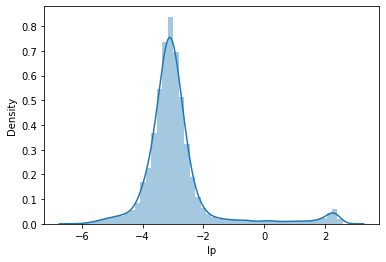

In [6]:
import seaborn as sns
sns.distplot(w_ss_df['lp'])

In [7]:
model = mavenn.load_example_model('mpsa_ge_pairwise')

Model loaded from these files:
	/Users/jkinney/github/mavenn/mavenn/examples/models/mpsa_ge_pairwise.pickle
	/Users/jkinney/github/mavenn/mavenn/examples/models/mpsa_ge_pairwise.h5


In [8]:
x = df.index.values
y = df['lp']
model.I_predictive(x=x, y=y)

(0.38360371812893734, 0.007058530108278609)

In [9]:
model.I_varlihood(x=x, y=y)

(0.34093724671164827, 0.01775808319571482)

In [10]:
data_df = mavenn.load_example_dataset('mpsa')
data_df.head()

,training_set,y,dy,x
0,False,-3.751854,0.444200,AAAGCAAAA
1,True,-2.697741,0.369972,AAAGCAAAC
2,True,-2.242947,0.575121,AAAGCAAAG
3,False,-3.067251,0.357014,AAAGCAAAT
4,False,-2.987074,0.472637,AAAGCAACA


In [11]:
ix = data_df['x'].isin(df.index)
x = data_df['x'][ix]
y = data_df['y'][ix]
model.I_varlihood(x=x, y=y)

(0.33823177359736256, 0.014426784273422075)

In [12]:
# Is there a difference between the measurements?
df_y = df['lp'].values
df['mpsa'] = data_df['y']

In [13]:
df.head()

,tot_ct,ex_ct,bc_ct,w_000,w_001,w_002,w_003,w_004,w_005,w_006,...,lp_096,lp_097,lp_098,lp_099,lp,lp_mean,lp_std,lp_terms,H,mpsa
ss,,,,,,,,,,,,,,,,,,,,,
AAAGCAAAA,106,2,15,26,20,20,14,5,24,13,...,-4.143135,-4.360973,-4.048051,-3.683094,-3.751854,-3.972169,0.534065,89,0.931163,NaN
AAAGCAAAC,96,6,14,10,17,12,13,21,14,15,...,-2.666159,-3.063391,-2.497979,-2.998669,-2.697741,-2.789193,0.308265,94,0.263143,NaN
AAAGCAAAG,89,6,18,19,8,25,17,5,25,19,...,-2.112964,-2.355032,NaN,-2.228477,-2.622436,-2.842751,0.568762,86,1.027740,NaN
AAAGCAAAT,311,14,27,25,25,31,23,19,32,25,...,-3.262361,-3.190234,-2.871680,-3.268531,-3.067251,-3.157403,0.447060,93,0.623549,NaN
AAAGCAACA,287,14,35,34,21,20,25,30,23,24,...,-2.451527,NaN,-3.039977,-2.066426,-2.987074,-3.138753,0.780977,88,1.506445,NaN


In [14]:
tmp_df = pd.merge(left=data_df, left_on='x', right=df[['lp_mean']], right_index=True)
tmp_df.head()

,training_set,y,dy,x,lp_mean
0,False,-3.751854,0.444200,AAAGCAAAA,-3.972169
1,True,-2.697741,0.369972,AAAGCAAAC,-2.789193
2,True,-2.242947,0.575121,AAAGCAAAG,-2.842751
3,False,-3.067251,0.357014,AAAGCAAAT,-3.157403
4,False,-2.987074,0.472637,AAAGCAACA,-3.138753


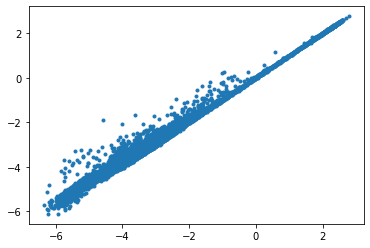

In [15]:
plt.plot(tmp_df['lp_mean'], tmp_df['y'], '.')